<a href="https://colab.research.google.com/github/KUNG1227/ML.EX/blob/main/LSTM_daSequenc_to_Sequenc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sys
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch.autograd import Variable

In [16]:
# 讀取資料
try:
  df = pd.read_csv('/content/load_feature_newdata.csv')
  print('load data in colab')
except:
  print('load data not in colab')
  sys.exit(0)

load data in colab


In [35]:
df.head()

,day,Pan1F,Pan2F,Liu1F,Liu2F,是否放假,測站氣壓(hPa),海平面氣壓(hPa),氣溫(℃),露點溫度(℃),相對溼度(%),風速(m-s),風向(360degree),最大瞬間風(m-s),最大瞬間風風向(360degree),降水量(mm),降水時數(h),日照時數(h),全天空日射量(MJ-㎡),紫外線指數
0,2023-01-20 00,0.19,0.16,0.31,0.17,1,1012.0,1013.1,21.6,17.6,78,1.2,340,2.9,360,0.0,0.0,0.0,0.0,0
1,2023-01-20 01,0.15,0.11,0.23,0.88,1,1012.0,1013.1,21.5,17.5,78,1.5,350,2.9,340,0.0,0.0,0.0,0.0,0
2,2023-01-20 02,0.18,0.10,0.23,0.78,1,1011.8,1012.9,21.6,17.2,76,0.7,360,3.0,340,0.0,0.0,0.0,0.0,0
3,2023-01-20 03,0.15,0.10,0.23,0.73,1,1011.6,1012.7,21.4,17.4,78,0.3,290,1.5,310,0.0,0.0,0.0,0.0,0
4,2023-01-20 04,0.18,0.10,0.23,0.72,1,1012.0,1013.1,21.7,17.7,78,0.6,150,1.3,140,0.0,0.0,0.0,0.0,0


In [59]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(22, 10),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("../input//content/load_feature_newdata.csv/")
your_data = pd.read_csv(
    data_dir / "/content/load_feature_newdata.csv",
    parse_dates=['day'],  # 确保'Date'列被解析为日期
    index_col='day',  # 将'Date'列设置为索引
)

# 如果需要，转换为适当的时间周期
your_data = your_data.to_period('H')  # 例如，转换为月周期

# 选择和重组数据
selected_features = your_data[['Pan1F', 'Pan2F']]  # 选择特征

selected_features = pd.concat({'Sales': selected_features}, names=[None, 'Industries'], axis=1)
selected_features.head()

Sales      
Industries       Pan1F Pan2F
day                         
2023-01-20 00:00  0.19  0.16
2023-01-20 01:00  0.15  0.11
2023-01-20 02:00  0.18  0.10
2023-01-20 03:00  0.15  0.10
2023-01-20 04:00  0.18  0.10

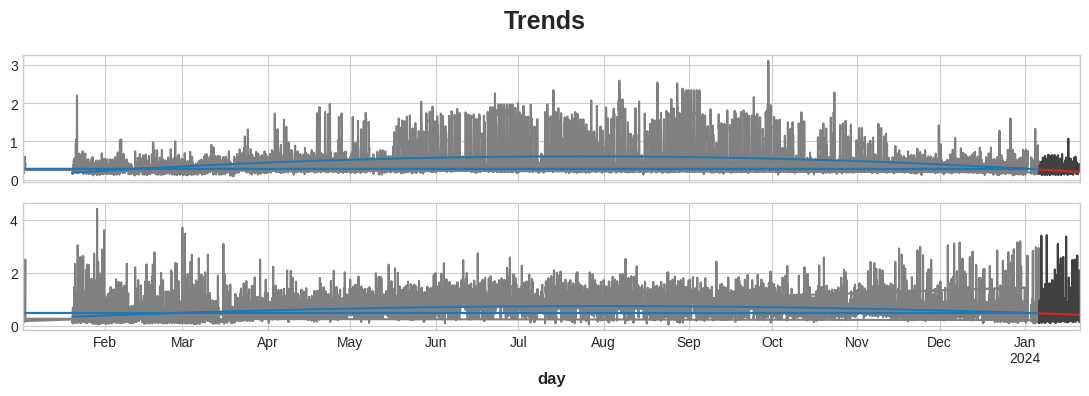

In [53]:
y = selected_features.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=360, shuffle=False,  # 设定为最后一个月的小时数
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.5', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [54]:
X = selected_features.stack()
display(X.head())
y = X.pop('Sales')

Sales
day              Industries       
2023-01-20 00:00 Pan1F        0.19
                 Pan2F        0.16
2023-01-20 01:00 Pan1F        0.15
                 Pan2F        0.11
2023-01-20 02:00 Pan1F        0.18

In [55]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["day"] = X.index.day  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [56]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

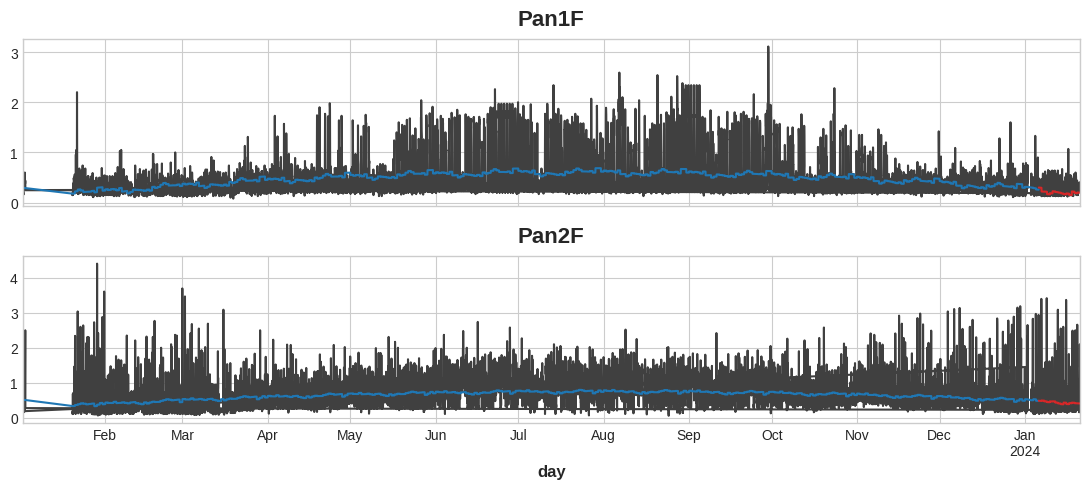

In [60]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['Pan1F', 'Pan2F'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])